<a href="https://colab.research.google.com/github/BrainsCorp/Deep-Learning-Guide/blob/main/GANs/GANs_FashionMNISTipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STUDENT NAME: VISHAL

In [1]:
# load pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## DATASET: FASHION MNIST
1. **taking subset of `FashionMNIST`**: *shoes*
1. 6000 Shoes Samples

In [3]:
#load dataset
data = datasets.FashionMNIST(root="dataset/", transform=transforms, download=True)

In [4]:
#labels
data.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
##getting images of shoes
print(sum(data.targets == 7))
data_shoes = data.data[data.targets == 7]
data_shoes.shape

tensor(6000)


torch.Size([6000, 28, 28])

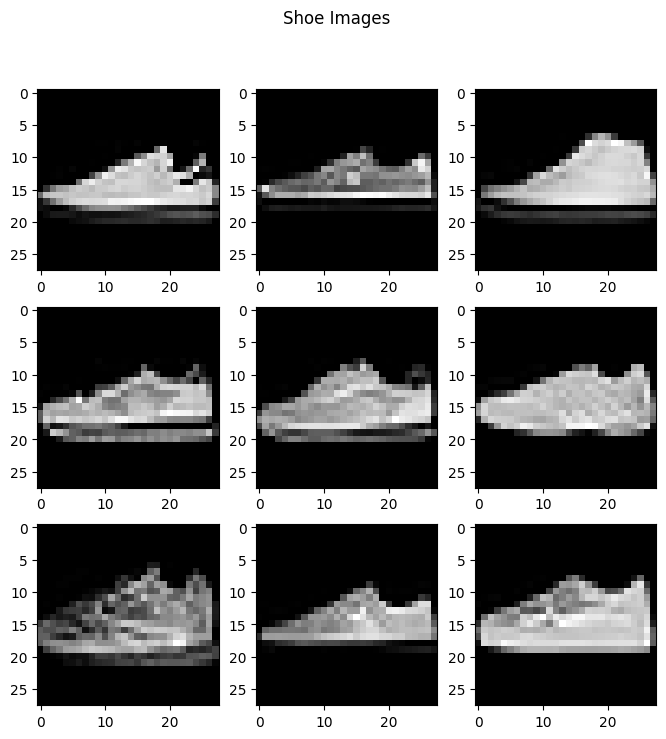

In [6]:
import matplotlib.pyplot as plt

sample = data_shoes[:9,:,:] #sample
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, img in enumerate(sample):
    ax.ravel()[i].imshow(img, cmap='gray')
    #ax.ravel()[i].set_axis_off()

plt.suptitle("Shoe Images")
plt.show()

## Model Architecture

## GANs
1. Generator Part\
  * Sequential Module (28 ➡ 512 ➡ 1024 ➡ 28)
  * Activation for Linear Layers (Leaky Relu)
  * BatchNorm1d at after Linear Layer
  * Activation for Output Layer (Sigmoid) vs (Tanh)
  * Applied Weight Initialization Technique (`he kaiming uniform`)
2. Discriminator Part\
  * Sequential Module (784 ➡ 128 ➡ 1)
  * Activation Output Sigmoid

In [22]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.discriminator = nn.Sequential(
        nn.Linear(img_dim, 128), #input
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1),
        nn.Sigmoid(), #softmax
    )
  def forward(self, x):
    return self.discriminator(x)

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.generator = nn.Sequential(
            nn.Linear(z_dim, 512), #input
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, img_dim), # Output layer
            nn.Sigmoid()  # Output activation for image generation
        )
    self._initialize_weights()
    self._batch_norm()

  #weight initialization
  def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
          #he_uniform technique
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

  def _batch_norm(self):
    for m in self.modules():
        if isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)

  def forward(self, x):
    return self.generator(x)

## HYPERPARAMETERS INITIALIZATION

In [23]:
import torchvision.transforms as transforms

#initializing variables
lr_disc = 1e-4
lr_gan = 1e-4

#initializing hyperparameter
Z_DIM = 28 #noise vector
IMAGE_DIM = 28 * 28 * 1 #image dimension
BATCH_SIZE = 32 #batch size
EPOCHS = 16 #number of epoch

#initialize model
disc = Discriminator(IMAGE_DIM).to(device)
gen = Generator(Z_DIM, IMAGE_DIM).to(device)

#fixed noise to test generator
fixed_noise = torch.randn((BATCH_SIZE, Z_DIM)).to(device)

#transformations
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [24]:
fixed_noise.shape

torch.Size([32, 28])

## DATALOADER AND OPTIMIZERS

In [25]:
loader = DataLoader(dataset = data_shoes, batch_size = BATCH_SIZE, shuffle=True)

#Optimizer for Discriminator
opt_disc = optim.Adam(disc.parameters(), lr=lr_disc)

#Optimizer for Generator
opt_gen = optim.Adam(gen.parameters(), lr=lr_gan)

#loss function
loss = nn.BCELoss()

# #TensorBoard
# writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
# writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

## TRAINING LOOP

In [26]:
step = 0

#sample generator images by generator
generated_images = []
real_images = []

#loss of models will store here
g_loss_disc = []
g_loss_gen = []

# Training Loop
for epoch in range(EPOCHS):
  avg_loss_disc = []
  avg_loss_gen = []

  for batch_idx, real in enumerate(loader):
    ##flatten input
    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    ##Generate noise
    noise = torch.randn(batch_size, Z_DIM).to(device)

    ## STEP 1: Generate batch fake images
    gen.train()
    fake = gen(noise)

    ### STEP 2: TRAIN Discrimator to classify fake or real
      ## 2.1 Real image loss
    disc.train()
    disc_real = disc(real.type(torch.float32)).view(-1)
    loss_disc_real = loss(disc_real, torch.ones_like(disc_real))

      ## 2.2 Fake image loss
    disc_fake = disc(fake).view(-1)
    loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))

      ## 2.3 average loss
    loss_disc = (loss_disc_real + loss_disc_fake) / 2

      ## Discriminator backward pass
    disc.zero_grad() #set gradient
    loss_disc.backward(retain_graph=True) #retain_graph? #calculate gradient
    opt_disc.step() #update weights

    ### ------------------------------------
    ### STEP 3: Train Generator based on discrimator eval
    disc.eval()
    output = disc(fake).view(-1) #why we do this thing again
    loss_gen = loss(output, torch.ones_like(output)) #? disc tells fake(0) but we need it be real(1)
    ## 3.1 Generator backward pass
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    ##
    avg_loss_disc.append(loss_disc.item())
    avg_loss_gen.append(loss_gen.item())

    ##results
    if batch_idx == batch_size-1:
      g_loss_disc.append(np.average(avg_loss_disc))
      g_loss_gen.append(np.average(avg_loss_gen))

      print(f"Epoch [{epoch}/ {EPOCHS}]",
            f"LossD : {np.average(avg_loss_disc):.4f}, LossG : {np.average(avg_loss_gen):.4f}", sep='\n')

      ##Store results
      with torch.no_grad():
        #evaluation of generator
        gen.eval()
        fake = gen(fixed_noise).reshape(-1, 28, 28).detach().cpu().numpy()
        data = real.reshape(-1, 28, 28).detach().cpu().numpy()

        generated_images.append(fake)
        real_images.append(data)
        # img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        # img_grid_real = torchvision.utils.make_grid(data, normalize=True)

        # writer_fake.add_image("Mnist Fake Images", img_grid_fake, global_step=step)
        # writer_real.add_image("Mnist Real Images", img_grid_real, global_step=step)

        step += 1


Epoch [0/ 16]
LossD : 0.2849, LossG : 1.1805
Epoch [1/ 16]
LossD : 0.0264, LossG : 3.6978
Epoch [2/ 16]
LossD : 0.2366, LossG : 4.9203
Epoch [3/ 16]
LossD : 0.3279, LossG : 4.0032
Epoch [4/ 16]
LossD : 0.3338, LossG : 1.3000
Epoch [5/ 16]
LossD : 0.3935, LossG : 0.9520
Epoch [6/ 16]
LossD : 0.6136, LossG : 1.0991
Epoch [7/ 16]
LossD : 0.5956, LossG : 1.3341
Epoch [8/ 16]
LossD : 0.2597, LossG : 1.1345
Epoch [9/ 16]
LossD : 0.2023, LossG : 1.4153
Epoch [10/ 16]
LossD : 0.2219, LossG : 1.4366
Epoch [11/ 16]
LossD : 0.2070, LossG : 1.6402
Epoch [12/ 16]
LossD : 0.3107, LossG : 1.6586
Epoch [13/ 16]
LossD : 0.1874, LossG : 1.8396
Epoch [14/ 16]
LossD : 0.3485, LossG : 1.6570
Epoch [15/ 16]
LossD : 0.0803, LossG : 2.0167


## VISUALIZE LOSSES

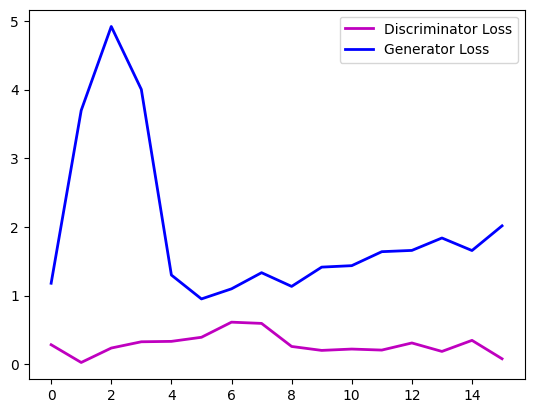

In [27]:
# visualizing loss of both Gen and Dis
plt.plot(g_loss_disc, label='Discriminator Loss', c='m', lw=2)
plt.plot(g_loss_gen, label='Generator Loss', c='b', lw=2)
plt.legend()
plt.show()

## SEE HOW GENERATOR IMPROVES AFTER EACH EPOCH

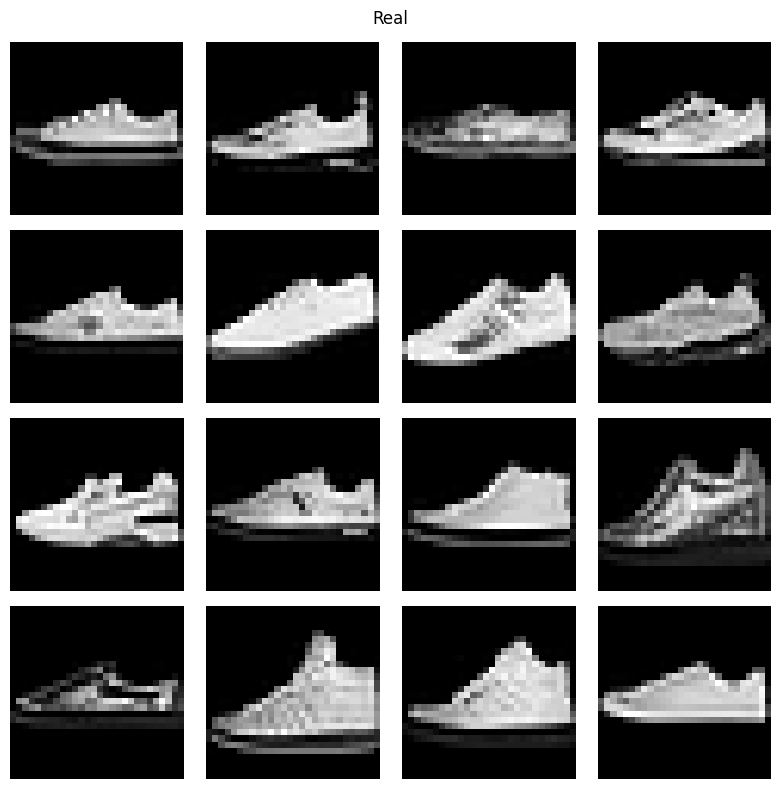

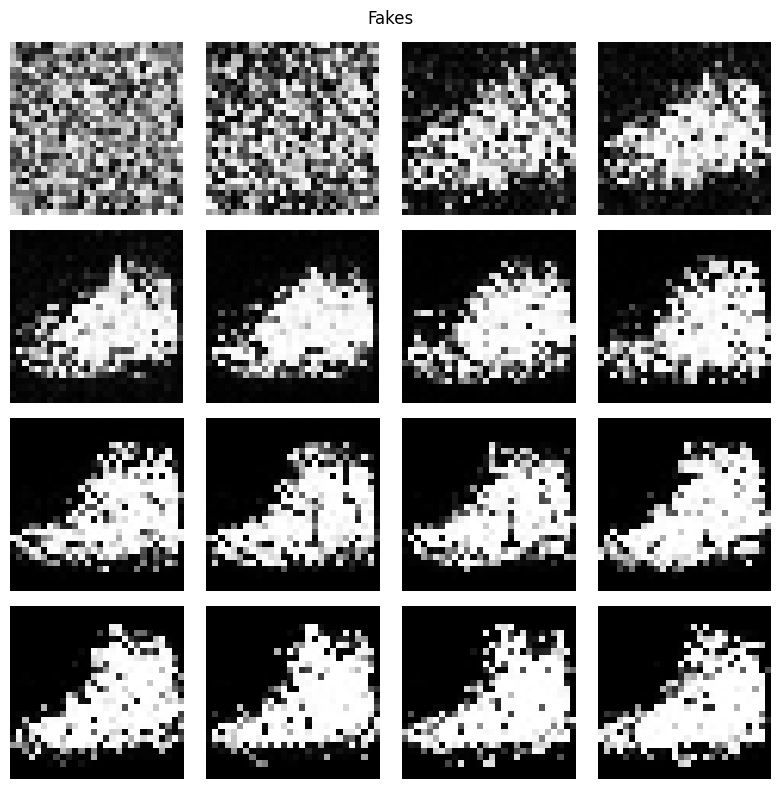

In [28]:
#display gan generated images through each epoch pass

def display_images(images, title, nrows=None, ncols=None):
  num_images = len(images)
  if nrows is None and ncols is None:
      # Automatic layout based on square root
      nrows = int(np.sqrt(num_images))
      ncols = int(np.ceil(num_images / nrows))
  elif nrows is None:
      # Calculate ncols based on provided nrows
      ncols = int(np.ceil(num_images / nrows))
  elif ncols is None:
      # Calculate nrows based on provided ncols
      nrows = int(np.ceil(num_images / ncols))

  fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8))  # Adjust figsize as needed

  # Iterate over images and axes, handling variable sizes
  for i in range(nrows):
      for j in range(ncols):
          if i * ncols + j < num_images:
              # Ensure valid index to avoid IndexError
              ax = axes[i, j]
              ax.imshow(images[i * ncols + j][2], cmap='gray')
              ax.axis('off')
          else:
              # Hide unused axes (optional)
              axes[i, j].axis('off')
              axes[i, j].set_visible(False)

  fig.suptitle(title)
  plt.tight_layout()
  plt.show()

display_images(real_images, "Real")
display_images(generated_images, "Fakes")

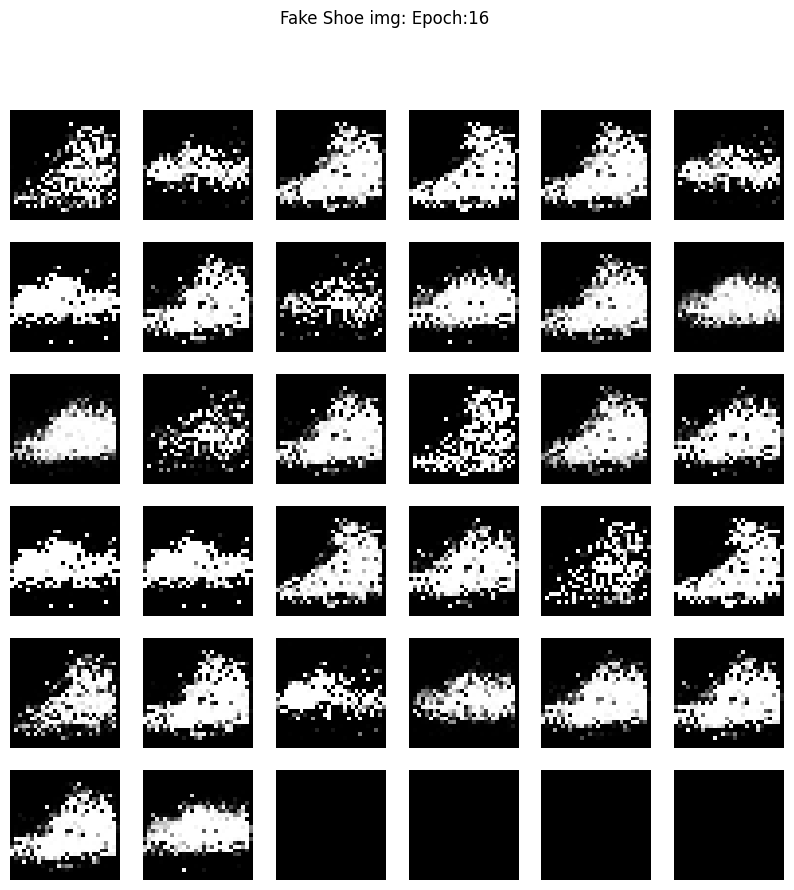

In [29]:
s = 6 # figure rows & columns
fig, ax = plt.subplots(s, s, figsize=(10, 10))
points = [(i, j) for i in range(s) for j in range(s)]
img_counter = 0

# see difference bw first epochs vs last epochs
epoch_no = 16 #define epoch no < epochs
for i, j in points:
  if img_counter < BATCH_SIZE:
    ax[i, j].imshow(generated_images[epoch_no-1][img_counter], cmap='gray')
    ax[i, j].set_axis_off()
  else:
    ax[i, j].imshow(np.ones((28, 28)), cmap='gray')
    ax[i, j].set_axis_off()
  img_counter += 1

plt.suptitle(f"Fake Shoe img: Epoch:{epoch_no}")
plt.show()

## TEST ON RANDOM EXAMPLE

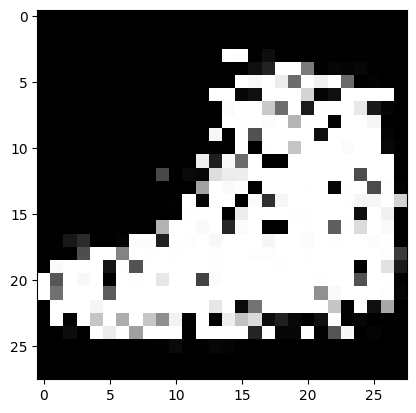

In [31]:
#random sample to Generator
gen.eval()
noise = torch.randn(1, Z_DIM)
sample = gen(noise).reshape(-1, 28, 28).detach().cpu().numpy()

plt.title("Fake Shoe Sample")
plt.imshow(sample[0], cmap='gray')
plt.show()

In [38]:
#What Discrimator outputs to this fake
disc.eval()
result = disc(torch.from_numpy(sample[0]).view(-1))

print(result)
print(f"Probability from Discrimintor that it's Fake: {1-result[0]:.2f}")
print(f"Probability from Discrimintor that it's Real: {result[0]:.2f}")

tensor([0.3271], grad_fn=<SigmoidBackward0>)
Probability from Discrimintor that it's Fake: 0.67
Probability from Discrimintor that it's Real: 0.33
